# Compute scattering coefficients

Edited by Louise, 28-02-2023

We show how to compute scattering coefficients. Starting with axisymmetric wavelets.


In [1]:
import s2wav.utils.shapes
from jax import jit, config
config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload

from PIL import Image
from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot



In [2]:
reload(plot)
plot.notebook_plot_format()

# Parameters
N = 3 is 5 orientations (2*N-1)

In [7]:
sampling = "mw"
L = 4
multiresolution = True
reality = False
N = 2
J_min = 0
nside = L/2

J = s2wav.utils.shapes.j_max(L)
print(J)

2


# Make a data map

(4, 7)
Target = Planet map (Ntheta, Nphi)= (4, 7)
Ilm (4, 7)


Text(0.5, 0, 'l indices')

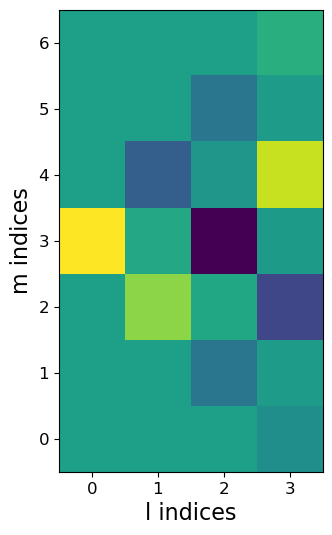

In [17]:
reload(sphlib)
# Random noise
# np.random.seed(2)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)
# Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)


### LSS
#I, Ilm = sphlib.make_MW_lensing(L, normalize=True, reality=reality)
#print('Target = LSS map')

### PySM
# I, Ilm = sphlib.make_pysm_sky(L, 'cmb', sampling=sampling, nest=False, normalize=True, reality=reality)
# print('Target = CMB map')

### Planet image
I, Ilm = sphlib.make_planet(L, 'venus', normalize=True, reality=reality)
print('Target = Planet map', '(Ntheta, Nphi)=', I.shape)
print('Ilm', Ilm.shape)


# Plot the map
# plt.figure(figsize=(8, 6))
# plt.imshow(I)
# hp.mollview(I)

plt.figure(figsize=(8, 6))
plt.imshow(np.real(Ilm.T), origin='lower')
plt.ylabel('m indices')
plt.xlabel('l indices')


# Build the wavelets

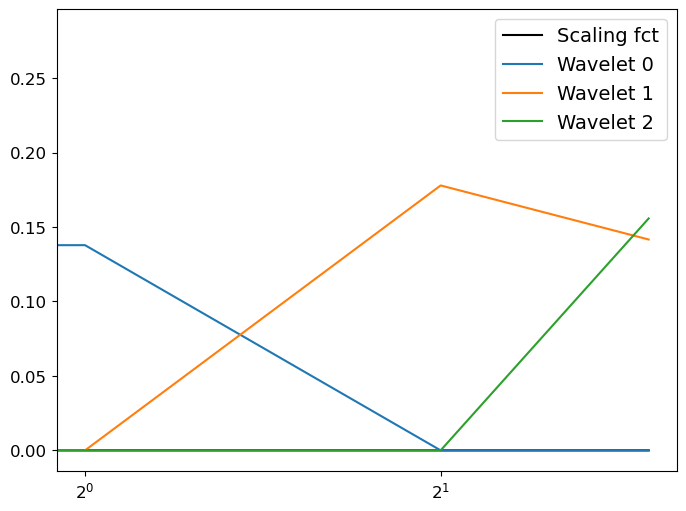

In [9]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)


filters = filters[0]

# Compute the scattering coefficients

In [15]:
reload(scatlib)

mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(
    Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)

W: 3 (3, 4, 7) (3, 4, 7) (3, 4, 7)
3 (3, 4, 7)
3 (3, 4, 7)
3 (3, 4, 7)
(2, 2, 3, 3, 3)
(1, 1, 3, 3, 3)


In [7]:
print(S1.shape, P00.shape, C01.shape, C11.shape)

(12,) (12,) (54,) (378,)


In [55]:
def get_idx_coeffs_S1_P00(L, N, J_min):
    J = s2wav.utils.shapes.j_max(L)
    print(J)
    NJ = J - J_min + 1  # Nb of scales
    print(NJ)
    Norient = 2 * N - 1   # Nb of orientations
    
    idx = np.zeros((2, Norient*NJ))
    i = 0
    for j in range(J_min, J+1):
        for n in range(Norient):
            idx[0, i] = j  # Scale indices
            idx[1, i] = n  # Orientation indices
            i += 1
    
    return idx     
        
idxS1_P00 = get_idx_coeffs_S1_P00(L, N, J_min)
print(idxS1_P00)

3
4
[[0. 0. 0. 1. 1. 1. 2. 2. 2. 3. 3. 3.]
 [0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2.]]


In [46]:
def get_idx_coeffs_C01(L, N, J_min):
    J = s2wav.utils.shapes.j_max(L)
    print(J)
    NJ = J - J_min + 1  # Nb of scales
    print(NJ)
    Norient = 2 * N - 1   # Nb of orientations
    
    idx_j1, idx_j2, idx_n1, idx_n2  = [], [], [], []

    for j1 in range(J_min, J):
        Nj2 = j1-J_min+1  # Number of j2 scales for a given j1
        C01_j1_idxj1 = np.zeros((Nj2, Norient, Norient))
        C01_j1_idxj2 = np.zeros_like(C01_j1_idxj1)
        C01_j1_idxn1 = np.zeros_like(C01_j1_idxj1)
        C01_j1_idxn2 = np.zeros_like(C01_j1_idxj1)
        
        for i, j2 in enumerate(range(J_min, j1+1)):
            for n1 in range(Norient):
                for n2 in range(Norient): 
                    C01_j1_idxj1[i, n1, n2] = j1
                    C01_j1_idxj2[i, n1, n2] = j2
                    C01_j1_idxn1[i, n1, n2] = n1
                    C01_j1_idxn2[i, n1, n2] = n2
                    
        idx_j1.append(C01_j1_idxj1)           
        idx_j2.append(C01_j1_idxj2)
        idx_n1.append(C01_j1_idxn1)
        idx_n2.append(C01_j1_idxn2)
    idx_j1 = np.concatenate(idx_j1, axis=None)
    idx_j2 = np.concatenate(idx_j2, axis=None)
    idx_n1 = np.concatenate(idx_n1, axis=None)
    idx_n2 = np.concatenate(idx_n2, axis=None)
    
    idxC01 = np.array((idx_j1, idx_j2, idx_n1, idx_n2))  # [4, NC01]
    
    return idxC01

idxC01 = get_idx_coeffs_C01(L, N, J_min)
print(idxC01.shape)
print(idxC01[3, :])

3
4
(4, 54)
[0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2.
 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2. 0. 1. 2.
 0. 1. 2. 0. 1. 2.]


In [47]:
def get_idx_coeffs_C11(L, N, J_min):
    J = s2wav.utils.shapes.j_max(L)
    print(J)
    NJ = J - J_min + 1  # Nb of scales
    print(NJ)
    Norient = 2 * N - 1   # Nb of orientations
    
    idx_j1, idx_j2, idx_j3, idx_n1, idx_n2, idx_n3 = [], [], [], [], [], []

    for j1 in range(J_min, J):
        Nj2 = j1-J_min+1 # Number of j2 scales for a given j1
        C11_j1_idxj1 = np.zeros((Nj2, Nj2, Norient, Norient, Norient))
        C11_j1_idxj2 = np.zeros_like(C11_j1_idxj1)
        C11_j1_idxj3 = np.zeros_like(C11_j1_idxj1)
        C11_j1_idxn1 = np.zeros_like(C11_j1_idxj1)
        C11_j1_idxn2 = np.zeros_like(C11_j1_idxj1)
        C11_j1_idxn3 = np.zeros_like(C11_j1_idxj1)
        
        for i2, j2 in enumerate(range(J_min, j1+1)):
            for i3, j3 in enumerate(range(J_min, j1+1)):
                for n1 in range(Norient):
                    for n2 in range(Norient): 
                        for n3 in range(Norient): 
                            C11_j1_idxj1[i2, i3, n1, n2, n3] = j1
                            C11_j1_idxj2[i2, i3, n1, n2, n3] = j2
                            C11_j1_idxj3[i2, i3, n1, n2, n3] = j3
                            C11_j1_idxn1[i2, i3, n1, n2, n3] = n1
                            C11_j1_idxn2[i2, i3, n1, n2, n3] = n2
                            C11_j1_idxn3[i2, i3, n1, n2, n3] = n3

        idx_j1.append(C11_j1_idxj1)           
        idx_j2.append(C11_j1_idxj2)
        idx_j3.append(C11_j1_idxj3)
        idx_n1.append(C11_j1_idxn1)
        idx_n2.append(C11_j1_idxn2)
        idx_n3.append(C11_j1_idxn3)
    idx_j1 = np.concatenate(idx_j1, axis=None)
    idx_j2 = np.concatenate(idx_j2, axis=None)
    idx_j3 = np.concatenate(idx_j3, axis=None)
    idx_n1 = np.concatenate(idx_n1, axis=None)
    idx_n2 = np.concatenate(idx_n2, axis=None)
    idx_n3 = np.concatenate(idx_n3, axis=None)
    
    idxC11 = np.array((idx_j1, idx_j2, idx_j3, idx_n1, idx_n2, idx_n3)) # [6, NC11]
    
    return idxC11

idxC11 = get_idx_coeffs_C11(L, N, J_min)
print(idxC11.shape)
print(idxC11[0, :])

3
4
(6, 378)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2

In [53]:
N

2

Text(0, 0.5, 'C01')

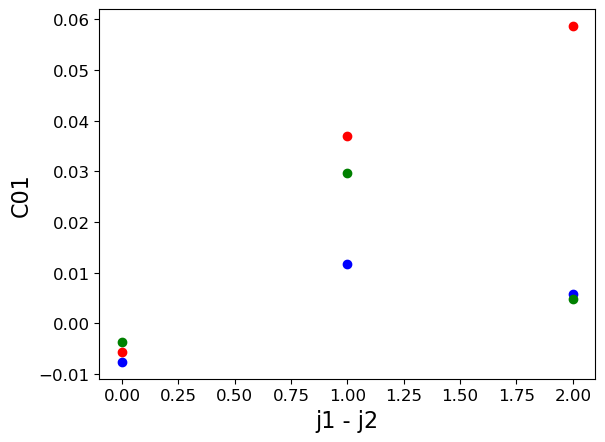

In [54]:
def select_C01(idxC01, j1, j2, n1, n2):
    
    idx = np.where((idxC01[0, :] == j1) & 
                   (idxC01[1, :] == j2) & 
                   (idxC01[2, :] == n1) & 
                   (idxC01[3, :] == n2))[0]
    return idx

j1 = 2

colorlist = ['b', 'g', 'r', 'orange', 'm']
plt.figure()
for j2 in range(J_min, j1+1):
    for n1 in range(2*N-1):
        for n2 in range(1):
            idx = select_C01(idxC01, j1=j1, j2=j2, n1=n1, n2=n2)

            color = colorlist[n1]
            plt.plot((idxC01[0, :] - idxC01[1, :])[idx], np.real(C01[idx]), 'o', color=color, label=f'{n1=}, {n2=}')
plt.xlabel('j1 - j2')
plt.ylabel('C01')
#plt.legend()

In [50]:
def select_C11(idxC11, j1, j2, j3, n1, n2, n3):
    
    idx = np.where((idxC11[0, :] == j1) & 
                   (idxC11[1, :] == j2) & 
                   (idxC11[2, :] == j3) &
                   (idxC11[3, :] == n1) & 
                   (idxC11[4, :] == n2) &
                   (idxC11[5, :] == n3))[0]
    return idx

In [51]:
# Average over orientations
avgS1 = np.average(S1.reshape(-1, 2*N-1), axis=1)
avgP00 = np.average(P00.reshape(-1, 2*N-1), axis=1)

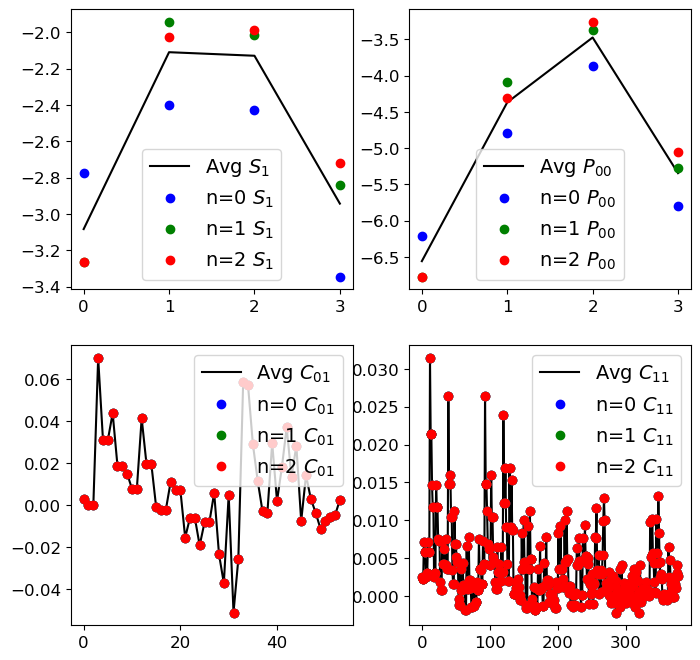

In [56]:
plot.plot_scatcov_coeffs(np.log2(avgS1), 
                         np.log2(avgP00), 
                         C01, 
                         C11, name='Avg', hold=True, color='k', ls='-')

colorlist = ['b', 'g', 'r', 'orange', 'm']
for n in range(2*N-1):
    # Select one orientation
    S1_one_orient = S1[np.where(idxS1_P00[1, :] == n)[0]]
    P00_one_orient = P00[np.where(idxS1_P00[1, :] == n)[0]]
    
    plot.plot_scatcov_coeffs(np.log2(S1_one_orient), 
                             np.log2(P00_one_orient), 
                             C01, 
                             C11, name=f'{n=}', hold=False, color=colorlist[n], ls='', marker='o')

In [24]:
print(C01)

[ 3.66100989e-04+1.17634659e-03j  3.66100989e-04+1.17634659e-03j
  3.66100989e-04+1.17634659e-03j  3.66100989e-04+1.17634659e-03j
  3.66100989e-04+1.17634659e-03j  2.03537779e-04-7.43678638e-04j
  2.03537779e-04-7.43678638e-04j  2.03537779e-04-7.43678638e-04j
  2.03537779e-04-7.43678638e-04j  2.03537779e-04-7.43678638e-04j
  2.60047976e-04+4.11436645e-04j  2.60047976e-04+4.11436645e-04j
  2.60047976e-04+4.11436645e-04j  2.60047976e-04+4.11436645e-04j
  2.60047976e-04+4.11436645e-04j  1.91460059e-04+7.77294567e-04j
  1.91460059e-04+7.77294567e-04j  1.91460059e-04+7.77294567e-04j
  1.91460059e-04+7.77294567e-04j  1.91460059e-04+7.77294567e-04j
 -2.56390474e-04-1.02733734e-04j -2.56390474e-04-1.02733734e-04j
 -2.56390474e-04-1.02733734e-04j -2.56390474e-04-1.02733734e-04j
 -2.56390474e-04-1.02733734e-04j  2.12610008e-04-4.69052780e-04j
  2.12610008e-04-4.69052780e-04j  2.12610008e-04-4.69052780e-04j
  2.12610008e-04-4.69052780e-04j  2.12610008e-04-4.69052780e-04j
  1.05590029e-03+6.689783

In [8]:
print(C11)

[0.00043946+0.j 0.00043946+0.j 0.00043946+0.j ... 0.00475499+0.j
 0.01919945+0.j 0.00399708+0.j]


# Check on white noise

In [9]:
# Check that C01 is compatible with 0 for white noise
nreals = 30
S1_all, P00_all, C01_all, C11_all = [], [], [], []
for i in range(nreals):
    print('real:', i)
    I = np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)
    Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)

    mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(
        Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)

    print(C01)
    print(C11)
    S1_all.append(S1)
    P00_all.append(P00)
    C01_all.append(C01)
    C11_all.append(C11)

S1_all = np.array(S1_all)
P00_all = np.array(P00_all)
C01_all = np.array(C01_all)
C11_all = np.array(C11_all)

real: 0
[ 4.52546343e-04-3.26666964e-04j  4.52546343e-04-3.26666964e-04j
  4.52546343e-04-3.26666964e-04j  4.52546343e-04-3.26666964e-04j
  4.52546343e-04-3.26666964e-04j  3.64787935e-04-5.09390833e-05j
  3.64787935e-04-5.09390833e-05j  3.64787935e-04-5.09390833e-05j
  3.64787935e-04-5.09390833e-05j  3.64787935e-04-5.09390833e-05j
  2.43030287e-04-5.68242800e-05j  2.43030287e-04-5.68242800e-05j
  2.43030287e-04-5.68242800e-05j  2.43030287e-04-5.68242800e-05j
  2.43030287e-04-5.68242800e-05j  7.83355162e-04+8.49539957e-05j
  7.83355162e-04+8.49539957e-05j  7.83355162e-04+8.49539957e-05j
  7.83355162e-04+8.49539957e-05j  7.83355162e-04+8.49539957e-05j
  3.52345698e-04-3.68708691e-05j  3.52345698e-04-3.68708691e-05j
  3.52345698e-04-3.68708691e-05j  3.52345698e-04-3.68708691e-05j
  3.52345698e-04-3.68708691e-05j -6.73625573e-04+3.34355516e-04j
 -6.73625573e-04+3.34355516e-04j -6.73625573e-04+3.34355516e-04j
 -6.73625573e-04+3.34355516e-04j -6.73625573e-04+3.34355516e-04j
  4.01023010e-04-

[ 2.84257216e-04+5.04100579e-04j  2.84257216e-04+5.04100579e-04j
  2.84257216e-04+5.04100579e-04j  2.84257216e-04+5.04100579e-04j
  2.84257216e-04+5.04100579e-04j -2.80236956e-04-4.61644373e-05j
 -2.80236956e-04-4.61644373e-05j -2.80236956e-04-4.61644373e-05j
 -2.80236956e-04-4.61644373e-05j -2.80236956e-04-4.61644373e-05j
  3.16269325e-04+4.69323036e-04j  3.16269325e-04+4.69323036e-04j
  3.16269325e-04+4.69323036e-04j  3.16269325e-04+4.69323036e-04j
  3.16269325e-04+4.69323036e-04j  7.43340186e-05+1.58337007e-04j
  7.43340186e-05+1.58337007e-04j  7.43340186e-05+1.58337007e-04j
  7.43340186e-05+1.58337007e-04j  7.43340186e-05+1.58337007e-04j
 -1.95271200e-04+2.14673852e-04j -1.95271200e-04+2.14673852e-04j
 -1.95271200e-04+2.14673852e-04j -1.95271200e-04+2.14673852e-04j
 -1.95271200e-04+2.14673852e-04j  9.04192768e-04+1.25792008e-03j
  9.04192768e-04+1.25792008e-03j  9.04192768e-04+1.25792008e-03j
  9.04192768e-04+1.25792008e-03j  9.04192768e-04+1.25792008e-03j
  7.29030549e-05+1.970612

[-4.25351902e-04+9.15883647e-04j -4.25351902e-04+9.15883647e-04j
 -4.25351902e-04+9.15883647e-04j -4.25351902e-04+9.15883647e-04j
 -4.25351902e-04+9.15883647e-04j  1.91019129e-05+1.21334100e-03j
  1.91019129e-05+1.21334100e-03j  1.91019129e-05+1.21334100e-03j
  1.91019129e-05+1.21334100e-03j  1.91019129e-05+1.21334100e-03j
 -1.31353894e-03-3.68386915e-04j -1.31353894e-03-3.68386915e-04j
 -1.31353894e-03-3.68386915e-04j -1.31353894e-03-3.68386915e-04j
 -1.31353894e-03-3.68386915e-04j  3.90724701e-04+1.52090700e-03j
  3.90724701e-04+1.52090700e-03j  3.90724701e-04+1.52090700e-03j
  3.90724701e-04+1.52090700e-03j  3.90724701e-04+1.52090700e-03j
 -6.06534233e-04+4.89747389e-04j -6.06534233e-04+4.89747389e-04j
 -6.06534233e-04+4.89747389e-04j -6.06534233e-04+4.89747389e-04j
 -6.06534233e-04+4.89747389e-04j  1.03369165e-03+7.64923804e-04j
  1.03369165e-03+7.64923804e-04j  1.03369165e-03+7.64923804e-04j
  1.03369165e-03+7.64923804e-04j  1.03369165e-03+7.64923804e-04j
  5.38291598e-04+1.770957

[ 5.61473131e-04+5.82721716e-04j  5.61473131e-04+5.82721716e-04j
  5.61473131e-04+5.82721716e-04j  5.61473131e-04+5.82721716e-04j
  5.61473131e-04+5.82721716e-04j  1.70673089e-04+3.29804307e-04j
  1.70673089e-04+3.29804307e-04j  1.70673089e-04+3.29804307e-04j
  1.70673089e-04+3.29804307e-04j  1.70673089e-04+3.29804307e-04j
  9.16608668e-05+9.66745603e-05j  9.16608668e-05+9.66745603e-05j
  9.16608668e-05+9.66745603e-05j  9.16608668e-05+9.66745603e-05j
  9.16608668e-05+9.66745603e-05j  2.73703342e-04+3.48818409e-04j
  2.73703342e-04+3.48818409e-04j  2.73703342e-04+3.48818409e-04j
  2.73703342e-04+3.48818409e-04j  2.73703342e-04+3.48818409e-04j
  2.08521375e-04+2.70695100e-04j  2.08521375e-04+2.70695100e-04j
  2.08521375e-04+2.70695100e-04j  2.08521375e-04+2.70695100e-04j
  2.08521375e-04+2.70695100e-04j -1.11881353e-03-1.16181260e-03j
 -1.11881353e-03-1.16181260e-03j -1.11881353e-03-1.16181260e-03j
 -1.11881353e-03-1.16181260e-03j -1.11881353e-03-1.16181260e-03j
 -9.13678244e-05-3.690924

[ 3.54600823e-05-1.89241946e-04j  3.54600823e-05-1.89241946e-04j
  3.54600823e-05-1.89241946e-04j  3.54600823e-05-1.89241946e-04j
  3.54600823e-05-1.89241946e-04j -1.64520273e-04-2.40596534e-04j
 -1.64520273e-04-2.40596534e-04j -1.64520273e-04-2.40596534e-04j
 -1.64520273e-04-2.40596534e-04j -1.64520273e-04-2.40596534e-04j
 -5.81636578e-05-4.00109176e-04j -5.81636578e-05-4.00109176e-04j
 -5.81636578e-05-4.00109176e-04j -5.81636578e-05-4.00109176e-04j
 -5.81636578e-05-4.00109176e-04j -5.84843048e-05-1.35028981e-04j
 -5.84843048e-05-1.35028981e-04j -5.84843048e-05-1.35028981e-04j
 -5.84843048e-05-1.35028981e-04j -5.84843048e-05-1.35028981e-04j
 -1.16745510e-05-1.28061907e-04j -1.16745510e-05-1.28061907e-04j
 -1.16745510e-05-1.28061907e-04j -1.16745510e-05-1.28061907e-04j
 -1.16745510e-05-1.28061907e-04j -4.94200939e-05-7.68448579e-07j
 -4.94200939e-05-7.68448579e-07j -4.94200939e-05-7.68448579e-07j
 -4.94200939e-05-7.68448579e-07j -4.94200939e-05-7.68448579e-07j
  1.07753247e-04+4.495437

[ 1.74663203e-04+3.21614227e-04j  1.74663203e-04+3.21614227e-04j
  1.74663203e-04+3.21614227e-04j  1.74663203e-04+3.21614227e-04j
  1.74663203e-04+3.21614227e-04j -1.90660858e-04+9.43812195e-05j
 -1.90660858e-04+9.43812195e-05j -1.90660858e-04+9.43812195e-05j
 -1.90660858e-04+9.43812195e-05j -1.90660858e-04+9.43812195e-05j
 -5.21891457e-06+1.02959102e-04j -5.21891457e-06+1.02959102e-04j
 -5.21891457e-06+1.02959102e-04j -5.21891457e-06+1.02959102e-04j
 -5.21891457e-06+1.02959102e-04j -1.20695250e-04+4.73786876e-06j
 -1.20695250e-04+4.73786876e-06j -1.20695250e-04+4.73786876e-06j
 -1.20695250e-04+4.73786876e-06j -1.20695250e-04+4.73786876e-06j
 -3.05794017e-04-3.66923860e-04j -3.05794017e-04-3.66923860e-04j
 -3.05794017e-04-3.66923860e-04j -3.05794017e-04-3.66923860e-04j
 -3.05794017e-04-3.66923860e-04j  1.68181323e-04-3.06177485e-04j
  1.68181323e-04-3.06177485e-04j  1.68181323e-04-3.06177485e-04j
  1.68181323e-04-3.06177485e-04j  1.68181323e-04-3.06177485e-04j
 -2.25055482e-04+3.343258

[ 4.64653871e-04-2.97714339e-04j  4.64653871e-04-2.97714339e-04j
  4.64653871e-04-2.97714339e-04j  4.64653871e-04-2.97714339e-04j
  4.64653871e-04-2.97714339e-04j  1.75657739e-04-5.78691931e-04j
  1.75657739e-04-5.78691931e-04j  1.75657739e-04-5.78691931e-04j
  1.75657739e-04-5.78691931e-04j  1.75657739e-04-5.78691931e-04j
  2.28266713e-03-5.35733630e-04j  2.28266713e-03-5.35733630e-04j
  2.28266713e-03-5.35733630e-04j  2.28266713e-03-5.35733630e-04j
  2.28266713e-03-5.35733630e-04j -8.91016430e-04+9.99010647e-05j
 -8.91016430e-04+9.99010647e-05j -8.91016430e-04+9.99010647e-05j
 -8.91016430e-04+9.99010647e-05j -8.91016430e-04+9.99010647e-05j
  7.71875474e-04-7.21424860e-04j  7.71875474e-04-7.21424860e-04j
  7.71875474e-04-7.21424860e-04j  7.71875474e-04-7.21424860e-04j
  7.71875474e-04-7.21424860e-04j  2.19792417e-04-3.28357691e-04j
  2.19792417e-04-3.28357691e-04j  2.19792417e-04-3.28357691e-04j
  2.19792417e-04-3.28357691e-04j  2.19792417e-04-3.28357691e-04j
 -3.58597805e-04+5.548238

[-7.97106512e-04+1.23785325e-04j -7.97106512e-04+1.23785325e-04j
 -7.97106512e-04+1.23785325e-04j -7.97106512e-04+1.23785325e-04j
 -7.97106512e-04+1.23785325e-04j -1.10225065e-04+1.69185733e-04j
 -1.10225065e-04+1.69185733e-04j -1.10225065e-04+1.69185733e-04j
 -1.10225065e-04+1.69185733e-04j -1.10225065e-04+1.69185733e-04j
  2.22527192e-04+3.89007787e-05j  2.22527192e-04+3.89007787e-05j
  2.22527192e-04+3.89007787e-05j  2.22527192e-04+3.89007787e-05j
  2.22527192e-04+3.89007787e-05j -2.45550427e-04+5.29656704e-05j
 -2.45550427e-04+5.29656704e-05j -2.45550427e-04+5.29656704e-05j
 -2.45550427e-04+5.29656704e-05j -2.45550427e-04+5.29656704e-05j
  8.13416230e-04+8.85646185e-05j  8.13416230e-04+8.85646185e-05j
  8.13416230e-04+8.85646185e-05j  8.13416230e-04+8.85646185e-05j
  8.13416230e-04+8.85646185e-05j  5.10991044e-04-4.75798456e-04j
  5.10991044e-04-4.75798456e-04j  5.10991044e-04-4.75798456e-04j
  5.10991044e-04-4.75798456e-04j  5.10991044e-04-4.75798456e-04j
 -1.30817829e-03+1.173685

[ 9.18275344e-04-7.37408097e-04j  9.18275344e-04-7.37408097e-04j
  9.18275344e-04-7.37408097e-04j  9.18275344e-04-7.37408097e-04j
  9.18275344e-04-7.37408097e-04j -2.00293949e-04-1.36994321e-04j
 -2.00293949e-04-1.36994321e-04j -2.00293949e-04-1.36994321e-04j
 -2.00293949e-04-1.36994321e-04j -2.00293949e-04-1.36994321e-04j
  2.84151339e-04-1.39357147e-03j  2.84151339e-04-1.39357147e-03j
  2.84151339e-04-1.39357147e-03j  2.84151339e-04-1.39357147e-03j
  2.84151339e-04-1.39357147e-03j  4.32447334e-04+6.68318752e-04j
  4.32447334e-04+6.68318752e-04j  4.32447334e-04+6.68318752e-04j
  4.32447334e-04+6.68318752e-04j  4.32447334e-04+6.68318752e-04j
  5.43734840e-06-4.26041690e-04j  5.43734840e-06-4.26041690e-04j
  5.43734840e-06-4.26041690e-04j  5.43734840e-06-4.26041690e-04j
  5.43734840e-06-4.26041690e-04j -1.55843495e-03-2.11652765e-03j
 -1.55843495e-03-2.11652765e-03j -1.55843495e-03-2.11652765e-03j
 -1.55843495e-03-2.11652765e-03j -1.55843495e-03-2.11652765e-03j
  2.61106725e-06+1.695720

[-3.83545242e-04-9.71933601e-05j -3.83545242e-04-9.71933601e-05j
 -3.83545242e-04-9.71933601e-05j -3.83545242e-04-9.71933601e-05j
 -3.83545242e-04-9.71933601e-05j -7.65587671e-04+5.88865317e-04j
 -7.65587671e-04+5.88865317e-04j -7.65587671e-04+5.88865317e-04j
 -7.65587671e-04+5.88865317e-04j -7.65587671e-04+5.88865317e-04j
  7.52586564e-05+6.47480069e-05j  7.52586564e-05+6.47480069e-05j
  7.52586564e-05+6.47480069e-05j  7.52586564e-05+6.47480069e-05j
  7.52586564e-05+6.47480069e-05j -5.86540066e-04+1.93830437e-04j
 -5.86540066e-04+1.93830437e-04j -5.86540066e-04+1.93830437e-04j
 -5.86540066e-04+1.93830437e-04j -5.86540066e-04+1.93830437e-04j
 -2.70776376e-04+4.08334024e-04j -2.70776376e-04+4.08334024e-04j
 -2.70776376e-04+4.08334024e-04j -2.70776376e-04+4.08334024e-04j
 -2.70776376e-04+4.08334024e-04j -2.63953659e-04-1.15645721e-04j
 -2.63953659e-04-1.15645721e-04j -2.63953659e-04-1.15645721e-04j
 -2.63953659e-04-1.15645721e-04j -2.63953659e-04-1.15645721e-04j
 -7.86837491e-04-6.588089

[ 1.44891809e-04+5.45443985e-04j  1.44891809e-04+5.45443985e-04j
  1.44891809e-04+5.45443985e-04j  1.44891809e-04+5.45443985e-04j
  1.44891809e-04+5.45443985e-04j -2.60314951e-05+1.29804038e-04j
 -2.60314951e-05+1.29804038e-04j -2.60314951e-05+1.29804038e-04j
 -2.60314951e-05+1.29804038e-04j -2.60314951e-05+1.29804038e-04j
  2.91541205e-04+4.05039509e-04j  2.91541205e-04+4.05039509e-04j
  2.91541205e-04+4.05039509e-04j  2.91541205e-04+4.05039509e-04j
  2.91541205e-04+4.05039509e-04j  1.60255275e-04+6.72861883e-05j
  1.60255275e-04+6.72861883e-05j  1.60255275e-04+6.72861883e-05j
  1.60255275e-04+6.72861883e-05j  1.60255275e-04+6.72861883e-05j
  8.07140288e-05-1.05504539e-04j  8.07140288e-05-1.05504539e-04j
  8.07140288e-05-1.05504539e-04j  8.07140288e-05-1.05504539e-04j
  8.07140288e-05-1.05504539e-04j  2.21514853e-04-5.49273956e-04j
  2.21514853e-04-5.49273956e-04j  2.21514853e-04-5.49273956e-04j
  2.21514853e-04-5.49273956e-04j  2.21514853e-04-5.49273956e-04j
 -5.26768904e-05+1.094619

[-2.65823807e-04-1.12181569e-04j -2.65823807e-04-1.12181569e-04j
 -2.65823807e-04-1.12181569e-04j -2.65823807e-04-1.12181569e-04j
 -2.65823807e-04-1.12181569e-04j  3.35219661e-05+6.61289240e-06j
  3.35219661e-05+6.61289240e-06j  3.35219661e-05+6.61289240e-06j
  3.35219661e-05+6.61289240e-06j  3.35219661e-05+6.61289240e-06j
  2.05095276e-04+8.83908615e-05j  2.05095276e-04+8.83908615e-05j
  2.05095276e-04+8.83908615e-05j  2.05095276e-04+8.83908615e-05j
  2.05095276e-04+8.83908615e-05j -4.75821932e-05+8.91122787e-05j
 -4.75821932e-05+8.91122787e-05j -4.75821932e-05+8.91122787e-05j
 -4.75821932e-05+8.91122787e-05j -4.75821932e-05+8.91122787e-05j
  2.37653422e-04+2.35300628e-04j  2.37653422e-04+2.35300628e-04j
  2.37653422e-04+2.35300628e-04j  2.37653422e-04+2.35300628e-04j
  2.37653422e-04+2.35300628e-04j  5.03162459e-05-7.48299468e-05j
  5.03162459e-05-7.48299468e-05j  5.03162459e-05-7.48299468e-05j
  5.03162459e-05-7.48299468e-05j  5.03162459e-05-7.48299468e-05j
 -9.13079347e-06+1.273343

[-4.54744770e-05+1.54089263e-05j -4.54744770e-05+1.54089263e-05j
 -4.54744770e-05+1.54089263e-05j -4.54744770e-05+1.54089263e-05j
 -4.54744770e-05+1.54089263e-05j -9.01821219e-05+5.92494756e-04j
 -9.01821219e-05+5.92494756e-04j -9.01821219e-05+5.92494756e-04j
 -9.01821219e-05+5.92494756e-04j -9.01821219e-05+5.92494756e-04j
  1.57716852e-04+5.32086895e-04j  1.57716852e-04+5.32086895e-04j
  1.57716852e-04+5.32086895e-04j  1.57716852e-04+5.32086895e-04j
  1.57716852e-04+5.32086895e-04j -5.23646336e-05+3.96683520e-04j
 -5.23646336e-05+3.96683520e-04j -5.23646336e-05+3.96683520e-04j
 -5.23646336e-05+3.96683520e-04j -5.23646336e-05+3.96683520e-04j
  3.33445556e-04+7.39919881e-04j  3.33445556e-04+7.39919881e-04j
  3.33445556e-04+7.39919881e-04j  3.33445556e-04+7.39919881e-04j
  3.33445556e-04+7.39919881e-04j -2.02614849e-04+1.18996460e-04j
 -2.02614849e-04+1.18996460e-04j -2.02614849e-04+1.18996460e-04j
 -2.02614849e-04+1.18996460e-04j -2.02614849e-04+1.18996460e-04j
 -6.55881315e-04-6.771779

[-1.19519634e-03+1.92585396e-05j -1.19519634e-03+1.92585396e-05j
 -1.19519634e-03+1.92585396e-05j -1.19519634e-03+1.92585396e-05j
 -1.19519634e-03+1.92585396e-05j  6.41637381e-04-2.85495671e-04j
  6.41637381e-04-2.85495671e-04j  6.41637381e-04-2.85495671e-04j
  6.41637381e-04-2.85495671e-04j  6.41637381e-04-2.85495671e-04j
 -9.13605907e-04+9.07654367e-05j -9.13605907e-04+9.07654367e-05j
 -9.13605907e-04+9.07654367e-05j -9.13605907e-04+9.07654367e-05j
 -9.13605907e-04+9.07654367e-05j -1.85174160e-05-1.47831796e-04j
 -1.85174160e-05-1.47831796e-04j -1.85174160e-05-1.47831796e-04j
 -1.85174160e-05-1.47831796e-04j -1.85174160e-05-1.47831796e-04j
  2.63946232e-04-1.85898108e-04j  2.63946232e-04-1.85898108e-04j
  2.63946232e-04-1.85898108e-04j  2.63946232e-04-1.85898108e-04j
  2.63946232e-04-1.85898108e-04j -5.36002792e-04+1.24303052e-04j
 -5.36002792e-04+1.24303052e-04j -5.36002792e-04+1.24303052e-04j
 -5.36002792e-04+1.24303052e-04j -5.36002792e-04+1.24303052e-04j
 -4.43809478e-04+1.487830

[-1.15189283e-04+5.06936153e-05j -1.15189283e-04+5.06936153e-05j
 -1.15189283e-04+5.06936153e-05j -1.15189283e-04+5.06936153e-05j
 -1.15189283e-04+5.06936153e-05j  5.58885170e-04-9.32693633e-05j
  5.58885170e-04-9.32693633e-05j  5.58885170e-04-9.32693633e-05j
  5.58885170e-04-9.32693633e-05j  5.58885170e-04-9.32693633e-05j
 -1.13186394e-04-4.68059111e-04j -1.13186394e-04-4.68059111e-04j
 -1.13186394e-04-4.68059111e-04j -1.13186394e-04-4.68059111e-04j
 -1.13186394e-04-4.68059111e-04j  9.73443183e-04+1.97062747e-04j
  9.73443183e-04+1.97062747e-04j  9.73443183e-04+1.97062747e-04j
  9.73443183e-04+1.97062747e-04j  9.73443183e-04+1.97062747e-04j
 -2.33958321e-04-2.01413358e-04j -2.33958321e-04-2.01413358e-04j
 -2.33958321e-04-2.01413358e-04j -2.33958321e-04-2.01413358e-04j
 -2.33958321e-04-2.01413358e-04j -1.12515779e-04+2.35020054e-05j
 -1.12515779e-04+2.35020054e-05j -1.12515779e-04+2.35020054e-05j
 -1.12515779e-04+2.35020054e-05j -1.12515779e-04+2.35020054e-05j
 -8.26122484e-04+5.333972

[-8.36877432e-04-4.02938550e-04j -8.36877432e-04-4.02938550e-04j
 -8.36877432e-04-4.02938550e-04j -8.36877432e-04-4.02938550e-04j
 -8.36877432e-04-4.02938550e-04j -8.49004175e-04-3.29223900e-05j
 -8.49004175e-04-3.29223900e-05j -8.49004175e-04-3.29223900e-05j
 -8.49004175e-04-3.29223900e-05j -8.49004175e-04-3.29223900e-05j
  1.63445305e-04+1.68850270e-04j  1.63445305e-04+1.68850270e-04j
  1.63445305e-04+1.68850270e-04j  1.63445305e-04+1.68850270e-04j
  1.63445305e-04+1.68850270e-04j -9.70644601e-04-6.27291929e-04j
 -9.70644601e-04-6.27291929e-04j -9.70644601e-04-6.27291929e-04j
 -9.70644601e-04-6.27291929e-04j -9.70644601e-04-6.27291929e-04j
 -4.67628184e-05+4.67576671e-05j -4.67628184e-05+4.67576671e-05j
 -4.67628184e-05+4.67576671e-05j -4.67628184e-05+4.67576671e-05j
 -4.67628184e-05+4.67576671e-05j -4.60502883e-04+6.51444922e-04j
 -4.60502883e-04+6.51444922e-04j -4.60502883e-04+6.51444922e-04j
 -4.60502883e-04+6.51444922e-04j -4.60502883e-04+6.51444922e-04j
 -4.63323937e-04+5.469845

[ 1.49593458e-04-4.62123970e-04j  1.49593458e-04-4.62123970e-04j
  1.49593458e-04-4.62123970e-04j  1.49593458e-04-4.62123970e-04j
  1.49593458e-04-4.62123970e-04j  3.94518321e-04-9.32467604e-05j
  3.94518321e-04-9.32467604e-05j  3.94518321e-04-9.32467604e-05j
  3.94518321e-04-9.32467604e-05j  3.94518321e-04-9.32467604e-05j
  3.55045839e-05-5.24531354e-04j  3.55045839e-05-5.24531354e-04j
  3.55045839e-05-5.24531354e-04j  3.55045839e-05-5.24531354e-04j
  3.55045839e-05-5.24531354e-04j  4.63531420e-04-3.89300439e-04j
  4.63531420e-04-3.89300439e-04j  4.63531420e-04-3.89300439e-04j
  4.63531420e-04-3.89300439e-04j  4.63531420e-04-3.89300439e-04j
  3.29666676e-06-1.78310253e-04j  3.29666676e-06-1.78310253e-04j
  3.29666676e-06-1.78310253e-04j  3.29666676e-06-1.78310253e-04j
  3.29666676e-06-1.78310253e-04j -8.08853680e-05-1.51441224e-04j
 -8.08853680e-05-1.51441224e-04j -8.08853680e-05-1.51441224e-04j
 -8.08853680e-05-1.51441224e-04j -8.08853680e-05-1.51441224e-04j
 -4.27125811e-05-1.061902

[-6.87071558e-04+9.25704029e-06j -6.87071558e-04+9.25704029e-06j
 -6.87071558e-04+9.25704029e-06j -6.87071558e-04+9.25704029e-06j
 -6.87071558e-04+9.25704029e-06j -1.03302256e-03-1.93227568e-04j
 -1.03302256e-03-1.93227568e-04j -1.03302256e-03-1.93227568e-04j
 -1.03302256e-03-1.93227568e-04j -1.03302256e-03-1.93227568e-04j
 -5.74990603e-04+2.91077814e-04j -5.74990603e-04+2.91077814e-04j
 -5.74990603e-04+2.91077814e-04j -5.74990603e-04+2.91077814e-04j
 -5.74990603e-04+2.91077814e-04j -6.34122749e-04+2.48262414e-05j
 -6.34122749e-04+2.48262414e-05j -6.34122749e-04+2.48262414e-05j
 -6.34122749e-04+2.48262414e-05j -6.34122749e-04+2.48262414e-05j
 -1.67689722e-03+1.07503466e-04j -1.67689722e-03+1.07503466e-04j
 -1.67689722e-03+1.07503466e-04j -1.67689722e-03+1.07503466e-04j
 -1.67689722e-03+1.07503466e-04j  1.16081551e-03+4.06978025e-04j
  1.16081551e-03+4.06978025e-04j  1.16081551e-03+4.06978025e-04j
  1.16081551e-03+4.06978025e-04j  1.16081551e-03+4.06978025e-04j
 -3.78508266e-04+8.254432

[-2.12934830e-05+1.52952278e-05j -2.12934830e-05+1.52952278e-05j
 -2.12934830e-05+1.52952278e-05j -2.12934830e-05+1.52952278e-05j
 -2.12934830e-05+1.52952278e-05j -5.87459970e-05-6.32962396e-04j
 -5.87459970e-05-6.32962396e-04j -5.87459970e-05-6.32962396e-04j
 -5.87459970e-05-6.32962396e-04j -5.87459970e-05-6.32962396e-04j
  5.68753888e-04-2.74426262e-04j  5.68753888e-04-2.74426262e-04j
  5.68753888e-04-2.74426262e-04j  5.68753888e-04-2.74426262e-04j
  5.68753888e-04-2.74426262e-04j -2.85980131e-04-6.78705622e-04j
 -2.85980131e-04-6.78705622e-04j -2.85980131e-04-6.78705622e-04j
 -2.85980131e-04-6.78705622e-04j -2.85980131e-04-6.78705622e-04j
  5.30181554e-05-3.71918265e-04j  5.30181554e-05-3.71918265e-04j
  5.30181554e-05-3.71918265e-04j  5.30181554e-05-3.71918265e-04j
  5.30181554e-05-3.71918265e-04j  6.17095151e-04+3.99553795e-04j
  6.17095151e-04+3.99553795e-04j  6.17095151e-04+3.99553795e-04j
  6.17095151e-04+3.99553795e-04j  6.17095151e-04+3.99553795e-04j
  5.70386027e-05+1.004738

[ 1.36319077e-04+1.47551673e-04j  1.36319077e-04+1.47551673e-04j
  1.36319077e-04+1.47551673e-04j  1.36319077e-04+1.47551673e-04j
  1.36319077e-04+1.47551673e-04j -2.82382132e-04-1.00992239e-04j
 -2.82382132e-04-1.00992239e-04j -2.82382132e-04-1.00992239e-04j
 -2.82382132e-04-1.00992239e-04j -2.82382132e-04-1.00992239e-04j
  3.03207681e-04+4.06862344e-04j  3.03207681e-04+4.06862344e-04j
  3.03207681e-04+4.06862344e-04j  3.03207681e-04+4.06862344e-04j
  3.03207681e-04+4.06862344e-04j -5.87201419e-04-3.96657325e-04j
 -5.87201419e-04-3.96657325e-04j -5.87201419e-04-3.96657325e-04j
 -5.87201419e-04-3.96657325e-04j -5.87201419e-04-3.96657325e-04j
  1.64238094e-04+4.49688428e-04j  1.64238094e-04+4.49688428e-04j
  1.64238094e-04+4.49688428e-04j  1.64238094e-04+4.49688428e-04j
  1.64238094e-04+4.49688428e-04j  5.81014069e-05+5.01336124e-04j
  5.81014069e-05+5.01336124e-04j  5.81014069e-05+5.01336124e-04j
  5.81014069e-05+5.01336124e-04j  5.81014069e-05+5.01336124e-04j
 -2.66106583e-04-2.873819

[-1.13891310e-03+9.01562533e-04j -1.13891310e-03+9.01562533e-04j
 -1.13891310e-03+9.01562533e-04j -1.13891310e-03+9.01562533e-04j
 -1.13891310e-03+9.01562533e-04j  7.82237427e-04-2.49177134e-04j
  7.82237427e-04-2.49177134e-04j  7.82237427e-04-2.49177134e-04j
  7.82237427e-04-2.49177134e-04j  7.82237427e-04-2.49177134e-04j
 -9.89384671e-04+7.19261927e-04j -9.89384671e-04+7.19261927e-04j
 -9.89384671e-04+7.19261927e-04j -9.89384671e-04+7.19261927e-04j
 -9.89384671e-04+7.19261927e-04j  3.99286175e-04-1.46572449e-06j
  3.99286175e-04-1.46572449e-06j  3.99286175e-04-1.46572449e-06j
  3.99286175e-04-1.46572449e-06j  3.99286175e-04-1.46572449e-06j
 -1.64038580e-04+3.00809479e-04j -1.64038580e-04+3.00809479e-04j
 -1.64038580e-04+3.00809479e-04j -1.64038580e-04+3.00809479e-04j
 -1.64038580e-04+3.00809479e-04j -9.84662761e-04+7.39163362e-04j
 -9.84662761e-04+7.39163362e-04j -9.84662761e-04+7.39163362e-04j
 -9.84662761e-04+7.39163362e-04j -9.84662761e-04+7.39163362e-04j
 -5.88308576e-04+6.842469

[-8.99546252e-04+1.22093706e-04j -8.99546252e-04+1.22093706e-04j
 -8.99546252e-04+1.22093706e-04j -8.99546252e-04+1.22093706e-04j
 -8.99546252e-04+1.22093706e-04j -1.39966533e-04-8.61029995e-06j
 -1.39966533e-04-8.61029995e-06j -1.39966533e-04-8.61029995e-06j
 -1.39966533e-04-8.61029995e-06j -1.39966533e-04-8.61029995e-06j
 -3.97336913e-04+2.77290349e-04j -3.97336913e-04+2.77290349e-04j
 -3.97336913e-04+2.77290349e-04j -3.97336913e-04+2.77290349e-04j
 -3.97336913e-04+2.77290349e-04j -6.92928554e-04-3.48904380e-04j
 -6.92928554e-04-3.48904380e-04j -6.92928554e-04-3.48904380e-04j
 -6.92928554e-04-3.48904380e-04j -6.92928554e-04-3.48904380e-04j
 -4.96917728e-04+2.98625059e-04j -4.96917728e-04+2.98625059e-04j
 -4.96917728e-04+2.98625059e-04j -4.96917728e-04+2.98625059e-04j
 -4.96917728e-04+2.98625059e-04j -8.63534263e-04-5.45019055e-05j
 -8.63534263e-04-5.45019055e-05j -8.63534263e-04-5.45019055e-05j
 -8.63534263e-04-5.45019055e-05j -8.63534263e-04-5.45019055e-05j
 -2.11085880e-04-9.940491

[ 7.00807816e-04-8.61870111e-04j  7.00807816e-04-8.61870111e-04j
  7.00807816e-04-8.61870111e-04j  7.00807816e-04-8.61870111e-04j
  7.00807816e-04-8.61870111e-04j  1.16818221e-03-2.27708504e-04j
  1.16818221e-03-2.27708504e-04j  1.16818221e-03-2.27708504e-04j
  1.16818221e-03-2.27708504e-04j  1.16818221e-03-2.27708504e-04j
  3.97303570e-04+1.05717521e-04j  3.97303570e-04+1.05717521e-04j
  3.97303570e-04+1.05717521e-04j  3.97303570e-04+1.05717521e-04j
  3.97303570e-04+1.05717521e-04j  1.66740532e-03-1.49698899e-03j
  1.66740532e-03-1.49698899e-03j  1.66740532e-03-1.49698899e-03j
  1.66740532e-03-1.49698899e-03j  1.66740532e-03-1.49698899e-03j
  4.06894475e-04-1.60350281e-04j  4.06894475e-04-1.60350281e-04j
  4.06894475e-04-1.60350281e-04j  4.06894475e-04-1.60350281e-04j
  4.06894475e-04-1.60350281e-04j -3.61082100e-04+1.53330769e-03j
 -3.61082100e-04+1.53330769e-03j -3.61082100e-04+1.53330769e-03j
 -3.61082100e-04+1.53330769e-03j -3.61082100e-04+1.53330769e-03j
  2.49243699e-04+4.304833

[ 1.49716468e-04+1.89249411e-04j  1.49716468e-04+1.89249411e-04j
  1.49716468e-04+1.89249411e-04j  1.49716468e-04+1.89249411e-04j
  1.49716468e-04+1.89249411e-04j  4.80039286e-05-1.08796672e-04j
  4.80039286e-05-1.08796672e-04j  4.80039286e-05-1.08796672e-04j
  4.80039286e-05-1.08796672e-04j  4.80039286e-05-1.08796672e-04j
  9.48346299e-04+3.92562495e-04j  9.48346299e-04+3.92562495e-04j
  9.48346299e-04+3.92562495e-04j  9.48346299e-04+3.92562495e-04j
  9.48346299e-04+3.92562495e-04j -2.83447856e-04-6.62142234e-05j
 -2.83447856e-04-6.62142234e-05j -2.83447856e-04-6.62142234e-05j
 -2.83447856e-04-6.62142234e-05j -2.83447856e-04-6.62142234e-05j
  4.44942782e-04+9.48056648e-05j  4.44942782e-04+9.48056648e-05j
  4.44942782e-04+9.48056648e-05j  4.44942782e-04+9.48056648e-05j
  4.44942782e-04+9.48056648e-05j  1.26575299e-04+2.80974529e-05j
  1.26575299e-04+2.80974529e-05j  1.26575299e-04+2.80974529e-05j
  1.26575299e-04+2.80974529e-05j  1.26575299e-04+2.80974529e-05j
 -3.85569976e-04-2.862190

[ 1.02764991e-03-2.72139067e-04j  1.02764991e-03-2.72139067e-04j
  1.02764991e-03-2.72139067e-04j  1.02764991e-03-2.72139067e-04j
  1.02764991e-03-2.72139067e-04j -7.36323705e-04+2.95773934e-04j
 -7.36323705e-04+2.95773934e-04j -7.36323705e-04+2.95773934e-04j
 -7.36323705e-04+2.95773934e-04j -7.36323705e-04+2.95773934e-04j
  9.76025545e-04-3.48601777e-04j  9.76025545e-04-3.48601777e-04j
  9.76025545e-04-3.48601777e-04j  9.76025545e-04-3.48601777e-04j
  9.76025545e-04-3.48601777e-04j  2.38576708e-05+3.50265294e-05j
  2.38576708e-05+3.50265294e-05j  2.38576708e-05+3.50265294e-05j
  2.38576708e-05+3.50265294e-05j  2.38576708e-05+3.50265294e-05j
 -1.81136115e-04+1.36500189e-04j -1.81136115e-04+1.36500189e-04j
 -1.81136115e-04+1.36500189e-04j -1.81136115e-04+1.36500189e-04j
 -1.81136115e-04+1.36500189e-04j  3.12338464e-04+5.56339678e-05j
  3.12338464e-04+5.56339678e-05j  3.12338464e-04+5.56339678e-05j
  3.12338464e-04+5.56339678e-05j  3.12338464e-04+5.56339678e-05j
 -3.11536444e-04+3.356104

[-1.85002769e-04-2.43063120e-04j -1.85002769e-04-2.43063120e-04j
 -1.85002769e-04-2.43063120e-04j -1.85002769e-04-2.43063120e-04j
 -1.85002769e-04-2.43063120e-04j  1.12999396e-04-1.00652777e-04j
  1.12999396e-04-1.00652777e-04j  1.12999396e-04-1.00652777e-04j
  1.12999396e-04-1.00652777e-04j  1.12999396e-04-1.00652777e-04j
 -6.33870053e-04-3.48831952e-04j -6.33870053e-04-3.48831952e-04j
 -6.33870053e-04-3.48831952e-04j -6.33870053e-04-3.48831952e-04j
 -6.33870053e-04-3.48831952e-04j  7.00329938e-04+6.27451472e-05j
  7.00329938e-04+6.27451472e-05j  7.00329938e-04+6.27451472e-05j
  7.00329938e-04+6.27451472e-05j  7.00329938e-04+6.27451472e-05j
  3.24488152e-05-2.30700087e-04j  3.24488152e-05-2.30700087e-04j
  3.24488152e-05-2.30700087e-04j  3.24488152e-05-2.30700087e-04j
  3.24488152e-05-2.30700087e-04j -1.43188928e-04-1.34096492e-04j
 -1.43188928e-04-1.34096492e-04j -1.43188928e-04-1.34096492e-04j
 -1.43188928e-04-1.34096492e-04j -1.43188928e-04-1.34096492e-04j
 -2.83439418e-04-2.693909

[-6.11483361e-04+1.66728113e-04j -6.11483361e-04+1.66728113e-04j
 -6.11483361e-04+1.66728113e-04j -6.11483361e-04+1.66728113e-04j
 -6.11483361e-04+1.66728113e-04j -2.04602704e-04-4.36325875e-04j
 -2.04602704e-04-4.36325875e-04j -2.04602704e-04-4.36325875e-04j
 -2.04602704e-04-4.36325875e-04j -2.04602704e-04-4.36325875e-04j
 -5.89890696e-04-5.19133059e-04j -5.89890696e-04-5.19133059e-04j
 -5.89890696e-04-5.19133059e-04j -5.89890696e-04-5.19133059e-04j
 -5.89890696e-04-5.19133059e-04j -9.48856165e-05-2.39679369e-05j
 -9.48856165e-05-2.39679369e-05j -9.48856165e-05-2.39679369e-05j
 -9.48856165e-05-2.39679369e-05j -9.48856165e-05-2.39679369e-05j
 -3.72340205e-04-7.15391488e-04j -3.72340205e-04-7.15391488e-04j
 -3.72340205e-04-7.15391488e-04j -3.72340205e-04-7.15391488e-04j
 -3.72340205e-04-7.15391488e-04j -7.72613210e-04-5.43404926e-04j
 -7.72613210e-04-5.43404926e-04j -7.72613210e-04-5.43404926e-04j
 -7.72613210e-04-5.43404926e-04j -7.72613210e-04-5.43404926e-04j
 -3.27792574e-04-1.228467

[ 1.82016838e-04+4.84874254e-06j  1.82016838e-04+4.84874254e-06j
  1.82016838e-04+4.84874254e-06j  1.82016838e-04+4.84874254e-06j
  1.82016838e-04+4.84874254e-06j -2.65568355e-04-5.10489408e-04j
 -2.65568355e-04-5.10489408e-04j -2.65568355e-04-5.10489408e-04j
 -2.65568355e-04-5.10489408e-04j -2.65568355e-04-5.10489408e-04j
  1.89093432e-05+7.79419316e-05j  1.89093432e-05+7.79419316e-05j
  1.89093432e-05+7.79419316e-05j  1.89093432e-05+7.79419316e-05j
  1.89093432e-05+7.79419316e-05j -1.70114598e-04-5.59224199e-05j
 -1.70114598e-04-5.59224199e-05j -1.70114598e-04-5.59224199e-05j
 -1.70114598e-04-5.59224199e-05j -1.70114598e-04-5.59224199e-05j
 -1.15213833e-06-3.58147579e-05j -1.15213833e-06-3.58147579e-05j
 -1.15213833e-06-3.58147579e-05j -1.15213833e-06-3.58147579e-05j
 -1.15213833e-06-3.58147579e-05j  1.46660243e-04+3.03870784e-04j
  1.46660243e-04+3.03870784e-04j  1.46660243e-04+3.03870784e-04j
  1.46660243e-04+3.03870784e-04j  1.46660243e-04+3.03870784e-04j
  2.41387684e-04+5.898358

[-3.28843290e-05-7.96031630e-05j -3.28843290e-05-7.96031630e-05j
 -3.28843290e-05-7.96031630e-05j -3.28843290e-05-7.96031630e-05j
 -3.28843290e-05-7.96031630e-05j -4.45583132e-04+2.66787277e-04j
 -4.45583132e-04+2.66787277e-04j -4.45583132e-04+2.66787277e-04j
 -4.45583132e-04+2.66787277e-04j -4.45583132e-04+2.66787277e-04j
  1.17409788e-04-1.56409966e-04j  1.17409788e-04-1.56409966e-04j
  1.17409788e-04-1.56409966e-04j  1.17409788e-04-1.56409966e-04j
  1.17409788e-04-1.56409966e-04j -2.59967942e-04+3.86292802e-04j
 -2.59967942e-04+3.86292802e-04j -2.59967942e-04+3.86292802e-04j
 -2.59967942e-04+3.86292802e-04j -2.59967942e-04+3.86292802e-04j
  8.28115385e-05-1.20003765e-04j  8.28115385e-05-1.20003765e-04j
  8.28115385e-05-1.20003765e-04j  8.28115385e-05-1.20003765e-04j
  8.28115385e-05-1.20003765e-04j  3.77569261e-04-4.52516772e-04j
  3.77569261e-04-4.52516772e-04j  3.77569261e-04-4.52516772e-04j
  3.77569261e-04-4.52516772e-04j  3.77569261e-04-4.52516772e-04j
 -5.04735853e-05-8.322616

[ 3.66100989e-04+1.17634659e-03j  3.66100989e-04+1.17634659e-03j
  3.66100989e-04+1.17634659e-03j  3.66100989e-04+1.17634659e-03j
  3.66100989e-04+1.17634659e-03j  2.03537779e-04-7.43678638e-04j
  2.03537779e-04-7.43678638e-04j  2.03537779e-04-7.43678638e-04j
  2.03537779e-04-7.43678638e-04j  2.03537779e-04-7.43678638e-04j
  2.60047976e-04+4.11436645e-04j  2.60047976e-04+4.11436645e-04j
  2.60047976e-04+4.11436645e-04j  2.60047976e-04+4.11436645e-04j
  2.60047976e-04+4.11436645e-04j  1.91460059e-04+7.77294567e-04j
  1.91460059e-04+7.77294567e-04j  1.91460059e-04+7.77294567e-04j
  1.91460059e-04+7.77294567e-04j  1.91460059e-04+7.77294567e-04j
 -2.56390474e-04-1.02733734e-04j -2.56390474e-04-1.02733734e-04j
 -2.56390474e-04-1.02733734e-04j -2.56390474e-04-1.02733734e-04j
 -2.56390474e-04-1.02733734e-04j  2.12610008e-04-4.69052780e-04j
  2.12610008e-04-4.69052780e-04j  2.12610008e-04-4.69052780e-04j
  2.12610008e-04-4.69052780e-04j  2.12610008e-04-4.69052780e-04j
  1.05590029e-03+6.689783

In [10]:
# Normalize by the STD over realisations
stdS1 = np.std(S1_all, axis=0)
stdP00 = np.std(P00_all, axis=0)
stdC01 = np.std(C01_all, axis=0)
stdC11 = np.std(C11_all, axis=0)

avgS1 = np.mean(S1_all, axis=0)
avgP00 = np.mean(P00_all, axis=0)
avgC01 = np.mean(C01_all, axis=0)
avgC11 = np.mean(C11_all, axis=0)

In [11]:
stdC11.shape


(6875,)

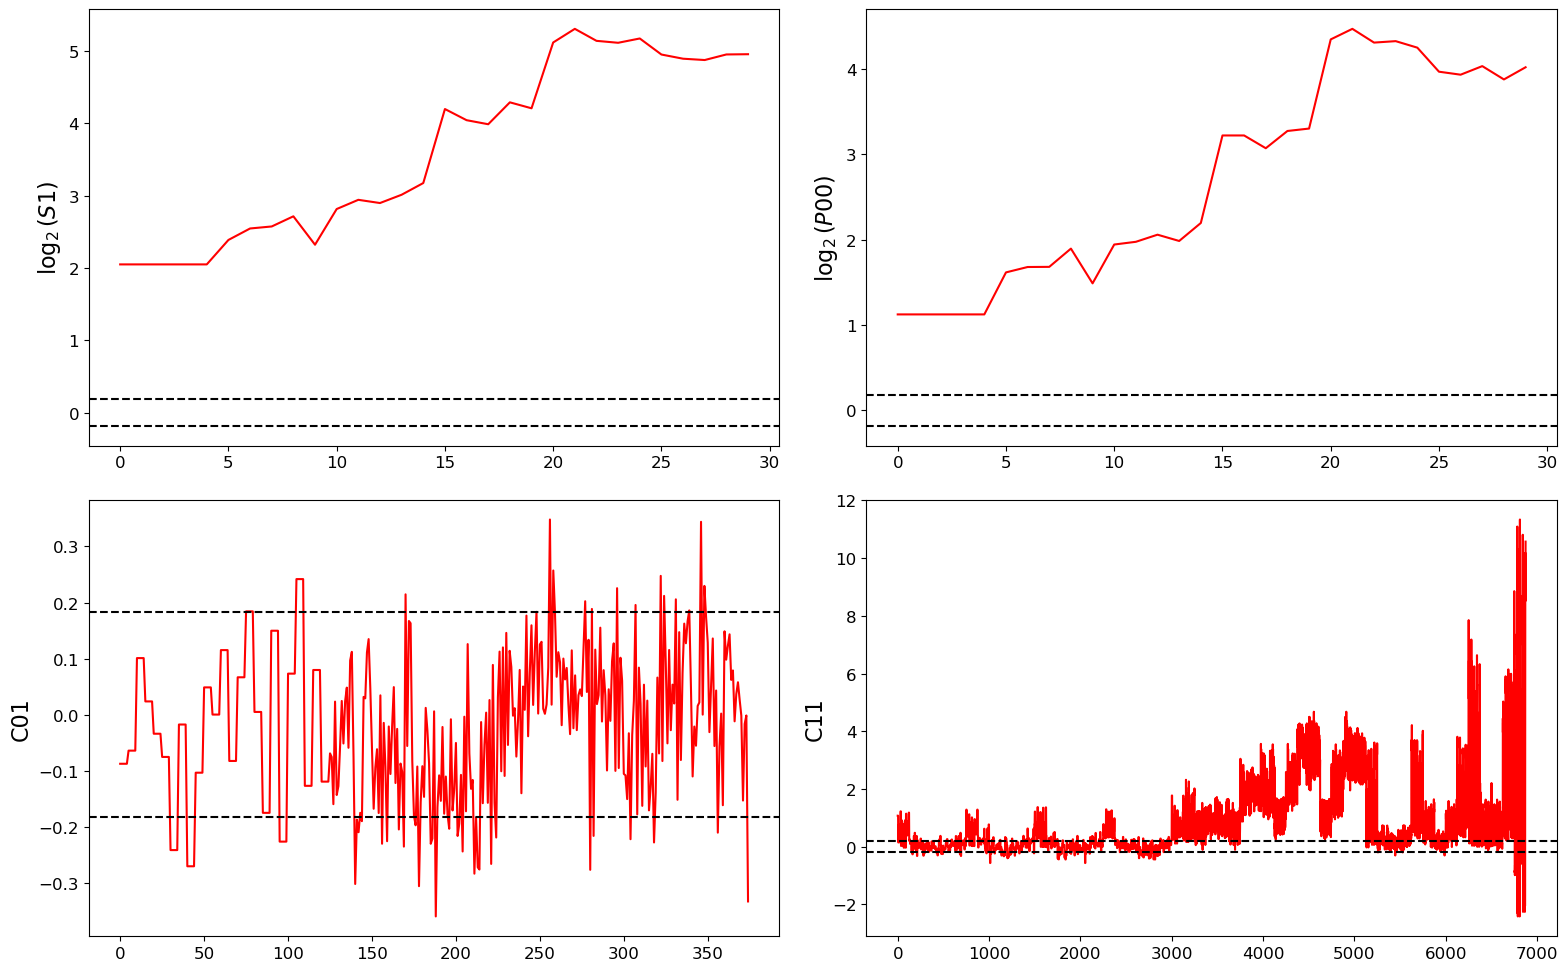

In [15]:
def forplot(ax):
    # ax.legend(fontsize=16)
    ax.axhline(-1/np.sqrt(nreals), color='k', ls='--')
    ax.axhline(1/np.sqrt(nreals), color='k', ls='--')
    return

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].plot(np.log2(avgS1 / stdS1), 'r')
axs[0].set_ylabel(r'$\log_2(S1)$', fontsize=16)
#forplot(axs[0])

axs[1].plot(np.log2(avgP00 / stdP00), 'r')
axs[1].set_ylabel(r'$\log_2(P00)$', fontsize=16)
#forplot(axs[1])

axs[2].plot(avgC01/stdC01, 'r')
axs[2].set_ylabel('C01', fontsize=16)
forplot(axs[2])
# axs[2].set_yscale('log')

axs[3].plot(avgC11/stdC11, 'r')
axs[3].set_ylabel('C11', fontsize=16)
forplot(axs[3])
# axs[3].set_yscale('log')

fig.tight_layout()

In [144]:
print(C11[:])

[-9.15744707e-05+8.83892392e-21j -9.15744707e-05+8.83892392e-21j
 -9.15744707e-05+8.83892392e-21j ...  1.46944530e-04-4.27005649e-13j
  2.08786748e-03+1.39721531e-11j -5.98486284e-05-7.50424319e-12j]
